In [27]:
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline

# 予測の不確実性
予測が実際に行われたあとでは、そのモデルに含まれる情報の相当量が失われている。  
ほとんどのクラス分類器には予測の不確実性を評価するためにdecision_functionメソッドまたはpredict_probaメソッドが用意されている。予測を行うことはdecition_functionやpredict_probaの出力を固定のスレッショルドで分けることを意味する。decicion_functionでは0だし、predict_probaでは0.5が鬪値になる。 

In [28]:
from mglearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

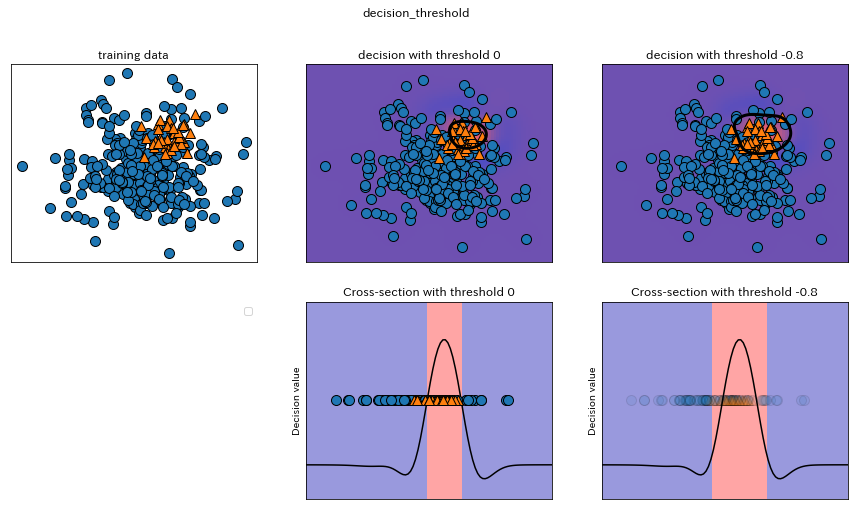

In [29]:
mglearn.plots.plot_decision_threshold()

上図は400点が陰性クラス、50点が陽性クラスの偏ったデータセットである。  
プロットにある黒い縁はdecision_functionの値がちょうど0になる場所で、この縁の内側は陽性と判断されて外側は陰性と判断される。

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



クラス1に対しては適合率も再現率も低い。クラス0が多いので分類器はクラス0を正しく分類することに集中してしまい、少ないクラス1の識別がうまくできていない。  
あるアプリケーションに対してクラス1の再現率を高めることが重要だとする。つまり偽陰性を制限することを求める場合だ。具体的な例でいうと地震警報の予測やガンの早期発見タスクなどだ。  
**スレッショルドを変更することで、「偽陽性は増えても構わないが偽陰性の数を減らす」といった要望に応えることができる。**今回の例ではより多くのデータポイントがクラス1に分類されるようにスレッショルドを小さくする。

In [31]:
y_pred_lower_threshold = svc.decision_function(X_test) > - .8

In [32]:
print(classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



予想通り(適合率と再現率がトレードオフ)クラス1の再現率が上がり、適合率が下がった。  
**適合率か制限率のどちらか一方を重視したい場合、もしくはデータが偏っている場合に一番簡単に良い結果を得る方法はdecision_functionのスレッショルドを変更する**ことだ。ただしdecition_functionのレンジはデータやモデルに依存するので最適なスレッショルドを決めるのに簡単なルールは存在しない  

predict_probaメソッドを実装しているモデルであれば、スレッショルドを設定するのは比較的簡単である。predict_probaは確率を表しているから、どのくらいの確信度でクラスを分けるかを決めればよい。確率値をいじる方が直感的ではあるが、**すべてのモデルが現実的な確信度モデルを持つわけではない(深さ指定していないDecisionTreeでは間違って場合でもつねに100%の確信度を持つ)。**較正されたモデルでは確信度に対して正確な予測の正答率を持つがどうやらそれは本の範疇を超えるとのこと。

モデルがクラス分類を行う判断の基準であるスレッショルドを変更することで、クラス分類器の適合率と再現率のトレードオフを調整することができる。  
陽性のサンプルを見落とす割合を10%に抑えたい場合(つまり偽陰性を抑制するから再現率を高める)を想定しよう。これは再現率が90%であることを意味する。アプリケーションによってこのように再現率が設定されたらそれに応じてスレッショルドを変更すればそれは常に可能である。しかし、**難しいのはこのようなスレッショルドでも適切な適合率が保てるようにモデルを開発することである**。すべて陽性だと判断すれば再現率は100%になるが、適合率が極端に低くなるし、そんなモデルは意味がない。  
再現率90%のように、クラス分類器に要請することをしばしば作動ポイント(operating point)の設定と呼ぶ。作動ポイントはアプリケーションによって異なるが、これを設定するのに**すべてのスレッショルドを試して適合率と再現率のトレードオフをグラフ化した適合率-再現率カーブ(precision-recall curve)**が役に立つ。

# 適合率-再現率カーブ(precision recall curve)

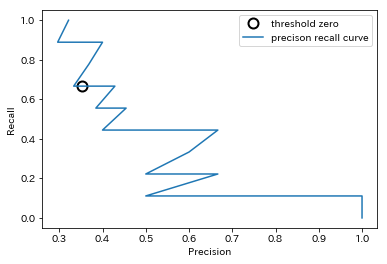

In [33]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
#ゼロに最も近いスレッショルドを探す
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.plot(precision, recall, label='precison recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()

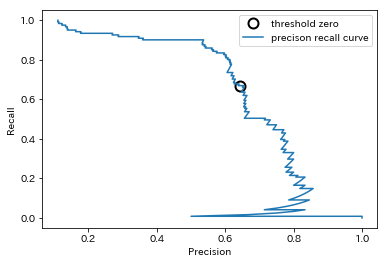

In [34]:
#カーブが滑らかになるようにデータポイントを増やす
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2], random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
#ゼロに最も近いスレッショルドを探す
close_zero = np.argmin(np.abs(thresholds))

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.plot(precision, recall, label='precison recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()

カーブの個々の点はdecision_functionの様々なスレッショルド値に対応する。黒い円はデフォルトのスレッショルド0の部分である(つまりpredictメソッドを呼び出したときに得られる適合率と再現率の値)。  
- カーブは左上の角から始まる。つまりスレッショルドが非常に低い場合に対応してすべて陽性と判断するために再現率が非常に高く、適合率が非常に低い。スレッショルドを大きくするとカーブは適合率を高くする方向に向かうが、今度は逆に再現率が低くなる。
- 図の右上に近い方が良いモデルである。つまり適合率も再現率も高い。  

図よりこのモデルでは高い再現率を保ったまま適合率を0.55くらいまで高めることができるが、それ以上適合率を上げようとすると再現率を犠牲にしなければならないことがわかる。

得意とするカーブの部分。つまり作動ポイントはしようするクラス分類器によってことなる。SVMとランダムフォレストでこれを比べてみる  
(RandomForestClassifierにはdecision_functionはなくpredict_probaしかない。precision_recall_curve関数の第一引数は陽性クラスの確信度尺度なので、サンプルがクラス1になる確率を渡せばよい)

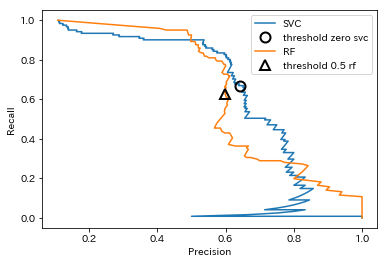

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

#predict_probaの第二エントリが陽性クラスの確信度
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(precision, recall, label='SVC')
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero svc', fillstyle='none', c='k', mew=2)

plt.plot(precision_rf, recall_rf, label='RF')

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', markersize=10, label='threshold 0.5 rf', fillstyle='none', c='k', mew=2)

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()

極端なケース、つまり非常に高い再現率や非常に高い適合率が要求される場合にはランダムフォレストの方が性能が良い。その中間あたりの再現率が0.7くらいではSVCの方が性能が良い(再現率の下げ幅に対してランダムフォレストより適合率をあげることができている)。

In [38]:
from sklearn.metrics import f1_score
print('f1-score of random forest: {:.3f}'.format(f1_score(y_test, rf.predict(X_test))))
print('f1-score of svc: {:.3f}'.format(f1_score(y_test, svc.predict(X_test))))

f1-score of random forest: 0.610
f1-score of svc: 0.656


**f1-scoreはデフォルトのスレッショルドで与えられる一点を表しているにすぎないのでこういった微妙な違いをみることはできない**

precision-recall curveを要約する方法の一つが、カーブの下の領域を積分する方法であり、これは平均適合率(average precision)と呼ばれる。

In [39]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print('Average precision of random forest: {:.3f}'.format(ap_rf)) 
print('Average precision of svc: {:.3f}'.format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


本ではRandomForestの方がスコアが高く、f1スコアとの逆転を示唆してたけどローカルの結果ではsvcの方が平均適合率が高くなりf1スコアと一致した。